# Descarga datos

In [ ]:
import requests
from pandas.io.json import json_normalize
import pandas as pd

url="https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=1000000000"
Datos=pd.read_json(url,convert_dates=['fecha_de_notificaci_n','fecha_de_muerte','fis','fecha_diagnostico','fecha_recuperado','fecha_reporte_web'])

In [ ]:
Datos.rename(columns={'id_de_caso':'id_caso','fecha_de_notificaci_n':'fecha_notificacion','c_digo_divipola':'codigo_municipio','ciudad_de_ubicaci_n':'ciudad',
                      'atenci_n':'atencion','tipo':'tipo_contagio','estado':'estado','pa_s_de_procedencia':'pais_procedencia','fis':'fecha_sintomas',
                      'tipo_recuperaci_n':'tipo_recuperacion','fecha_de_muerte':'fecha_muerte'},inplace=True)

In [ ]:
Datos

,id_caso,fecha_notificacion,codigo_municipio,ciudad,departamento,atencion,edad,sexo,tipo_contagio,estado,pais_procedencia,fecha_sintomas,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperacion,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_muerte
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06,2020-03-13,2020-03-06,PCR,11,380.0,Otro,NaN,NaT
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04T00:00:00.000,2020-03-09,2020-03-19,2020-03-09,PCR,76,724.0,Otro,NaN,NaT
2,3,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29T00:00:00.000,2020-03-09,2020-03-15,2020-03-09,PCR,5,724.0,Otro,NaN,NaT
3,4,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06T00:00:00.000,2020-03-11,2020-03-26,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
4,5,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08T00:00:00.000,2020-03-11,2020-03-23,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650057,650098,2020-08-23,5147,Carepa,Antioquia,Casa,39,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
650058,650099,2020-08-23,5266,Envigado,Antioquia,Casa,40,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
650059,650100,2020-08-23,5360,Itagüí,Antioquia,Casa,58,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
650060,650101,2020-08-23,5360,Itagüí,Antioquia,Casa,78,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT


# Análisis datos y dataset final para modelar

In [ ]:
# Cuenta vacíos
Datos.isna().sum()

id_caso                     0
fecha_notificacion          0
codigo_municipio            0
ciudad                      0
departamento                0
atencion                    0
edad                        0
sexo                        0
tipo_contagio               0
estado                      0
pais_procedencia       649097
fecha_sintomas              0
fecha_diagnostico        3976
fecha_recuperado       151836
fecha_reporte_web           0
tipo_recuperacion      151841
codigo_departamento         0
codigo_pais            649101
pertenencia_etnica     366607
nombre_grupo_etnico    638737
fecha_muerte           627849
dtype: int64

In [ ]:
# 5 principales ciudades: Bogotá, Medellín, Cali, Barranquilla y Cartagena de Indias, coincide con las de más casos
Datos['ciudad'].value_counts().head(10)

Bogotá D.C.            221738
Medellín                49932
Cali                    38466
Barranquilla            36520
Cartagena de Indias     20758
Soledad                 13922
Montería                12613
Valledupar               9127
Bucaramanga              9047
Soacha                   8941
Name: ciudad, dtype: int64

In [ ]:
# filtrando ciudades
Datos1=Datos[Datos['ciudad'].isin(['Bogotá D.C.'])]
Datos1.reset_index(inplace=True,drop=True)
Datos1

,id_caso,fecha_notificacion,codigo_municipio,ciudad,departamento,atencion,edad,sexo,tipo_contagio,estado,pais_procedencia,fecha_sintomas,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperacion,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_muerte
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06,2020-03-13,2020-03-06,PCR,11,380.0,Otro,NaN,NaT
1,8,2020-03-09,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,22,F,Importado,Leve,ESPAÑA,2020-03-06T00:00:00.000,2020-03-11,2020-03-21,2020-03-11,PCR,11,724.0,Otro,NaN,NaT
2,9,2020-03-08,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,28,F,Importado,Leve,ESPAÑA,2020-03-07T00:00:00.000,2020-03-11,2020-03-23,2020-03-11,PCR,11,724.0,Otro,NaN,NaT
3,10,2020-03-12,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,36,F,Importado,Leve,ESPAÑA,2020-03-06T00:00:00.000,2020-03-12,2020-03-21,2020-03-12,PCR,11,724.0,Otro,NaN,NaT
4,11,2020-03-11,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,42,F,Importado,Leve,ESPAÑA,2020-03-06T00:00:00.000,2020-03-12,2020-03-31,2020-03-12,PCR,11,724.0,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221733,647955,2020-08-24,11001,Bogotá D.C.,Bogotá D.C.,Casa,64,M,En estudio,Asintomático,NaN,Asintomático,2020-08-28,NaT,2020-09-04,NaN,11,NaN,NaN,NaN,NaT
221734,647956,2020-08-25,11001,Bogotá D.C.,Bogotá D.C.,Casa,24,M,En estudio,Asintomático,NaN,Asintomático,2020-08-28,NaT,2020-09-04,NaN,11,NaN,NaN,NaN,NaT
221735,647957,2020-08-26,11001,Bogotá D.C.,Bogotá D.C.,Casa,40,F,En estudio,Asintomático,NaN,Asintomático,2020-08-27,NaT,2020-09-04,NaN,11,NaN,NaN,NaN,NaT
221736,647958,2020-08-26,11001,Bogotá D.C.,Bogotá D.C.,Casa,34,M,En estudio,Asintomático,NaN,Asintomático,2020-08-27,NaT,2020-09-04,NaN,11,NaN,NaN,NaN,NaT


# **Metodologías propuestas y desarrollo de los modelos**

## Metodología 1: Nuevos ARIMA Y POLINOMIAL CON ERORRES ARIMA

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

In [ ]:
tabla_nuevos

,fecha_reporte_web,casos_nuevos_reportados,casos_confirmados
0,2020-03-06,1,1
1,2020-03-11,2,3
2,2020-03-12,2,5
3,2020-03-13,1,6
4,2020-03-14,10,16
...,...,...,...
171,2020-08-28,2182,204067
172,2020-08-29,3338,207405
173,2020-08-30,1846,209251
174,2020-08-31,2049,211300


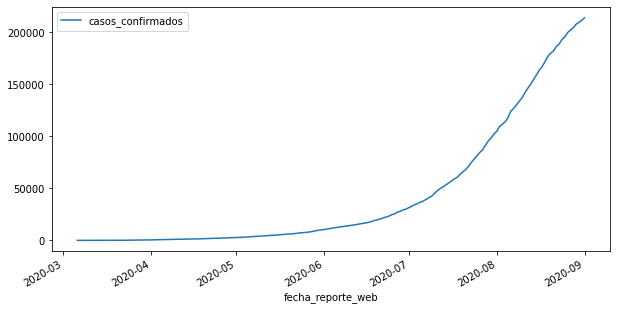

In [ ]:
# los casos confirmados no pueden ser con modelo basado en la tendencia, se tiene que predecir con el resultado de la suma de los casos nuevos reportados
tabla_nuevos.plot(x='fecha_reporte_web',y='casos_confirmados',figsize=(10, 5)).figure.savefig('1.png')

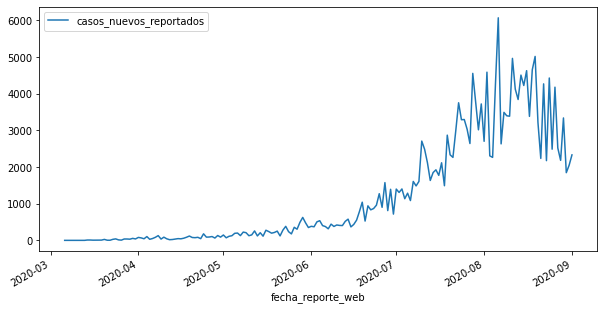

In [ ]:
tabla_nuevos.plot(x='fecha_reporte_web',y='casos_nuevos_reportados',figsize=(10, 5)).figure.savefig('2.png')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


mean1=138.659091, mean2=2288.965909
variance1=19942.520145, variance2=1972372.237474


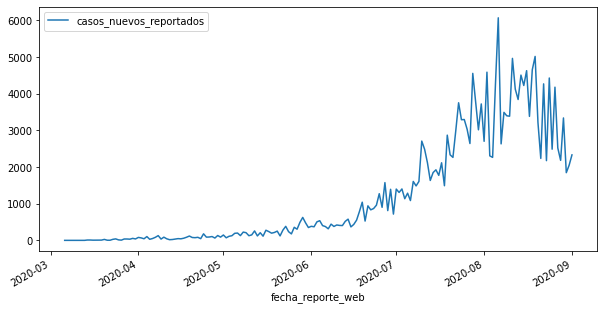

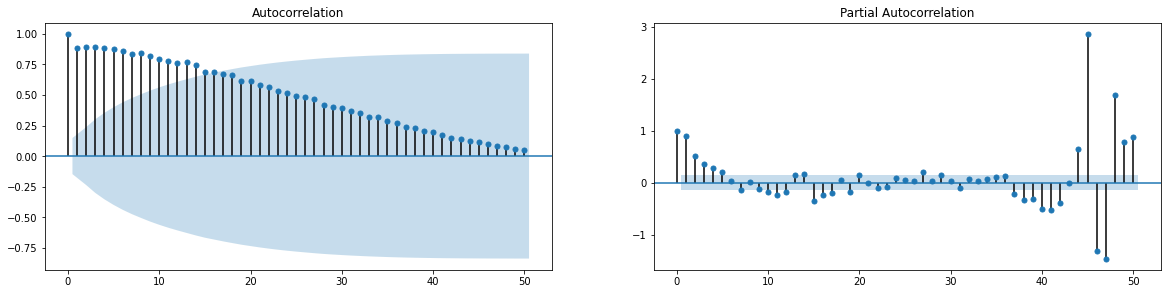

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M1Nuevos=M1Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)
M1Nuevos.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Nuevos.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Nuevos, lags=50, ax=ax2)

X=M1Nuevos.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


mean1=4.223304, mean2=7.487953
variance1=2.145961, variance2=0.599499


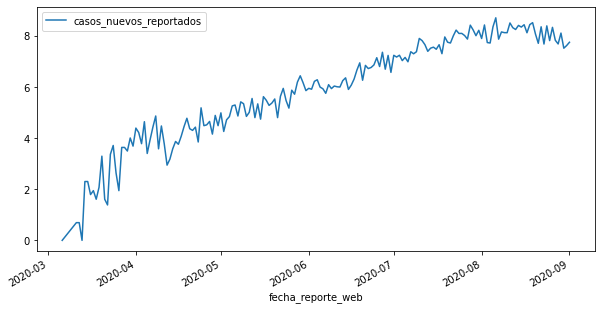

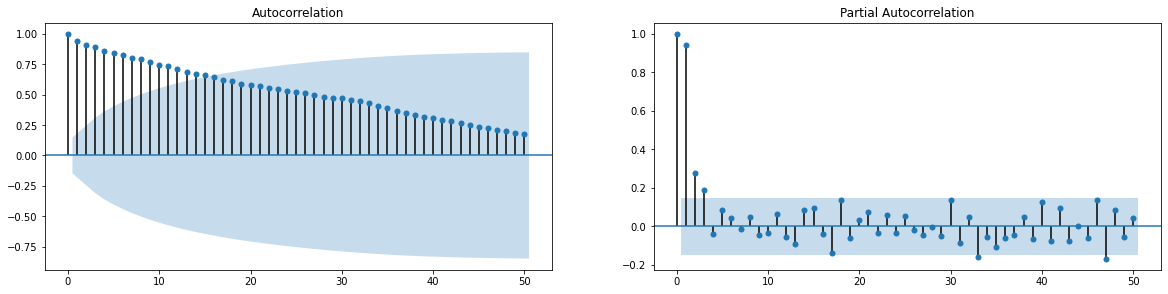

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1NuevosLog=np.log(M1Nuevos)
plt.rcParams["figure.figsize"] = (10,5)
M1NuevosLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1NuevosLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1NuevosLog, lags=50, ax=ax2)

X=M1NuevosLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

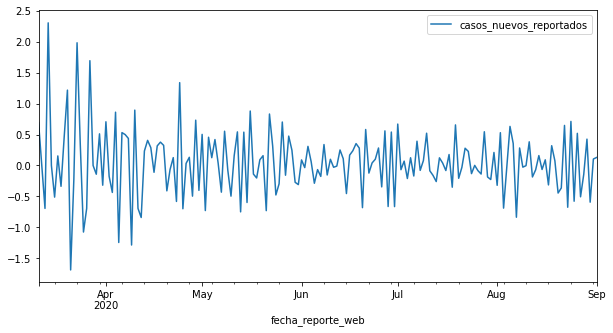

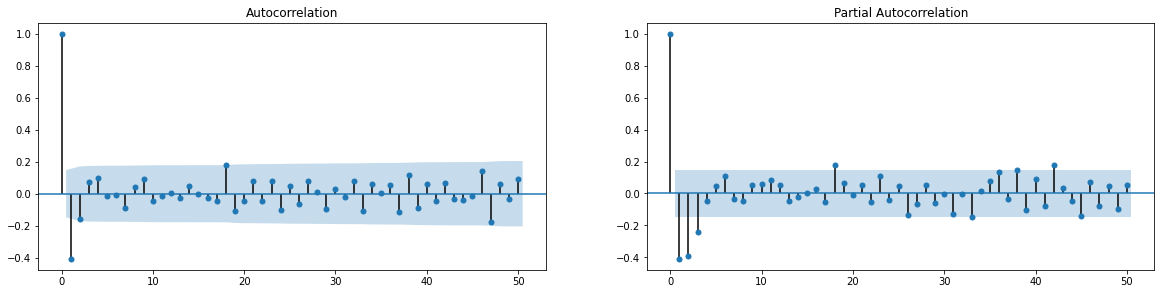

In [ ]:
# Primera diferencia para volver estacional
M1NuevosLogDif=M1NuevosLog.diff()
M1NuevosLogDif=M1NuevosLogDif[1:]
M1NuevosLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1NuevosLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1NuevosLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1NuevosLogTrain=M1NuevosLog[:int(len(M1NuevosLog)*p_train)]
M1NuevosLogTest=M1NuevosLog[int(len(M1NuevosLog)*p_train):int(len(M1NuevosLog)*(p_train+p_test))]
M1NuevosLogForecast=M1NuevosLog[int(len(M1NuevosLog)*(p_train+p_test)):]
print(M1NuevosLog.shape)
print(M1NuevosLogTrain.shape)
print(M1NuevosLogTest.shape)
print(M1NuevosLogForecast.shape)

(176, 1)
(140, 1)
(21, 1)
(15, 1)


In [ ]:
pip install pmdarima

In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1NuevosLogTrain)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  140
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -92.237
Date:                Wed, 02 Sep 2020   AIC                            190.475
Time:                        18:20:06   BIC                            199.278
Sample:                             0   HQIC                           194.052
                                - 140                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0539      0.014      3.782      0.000       0.026       0.082
ma.L1         -0.6800      0.056    -12.072      0.000      -0.790      -0.570
sigma2         0.2198      0.020     11.250      0.000       0.181       0.258
===================================================================================
Ljung-Box (Q):                       29.18   Jarque-Bera (JB):                29.29
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


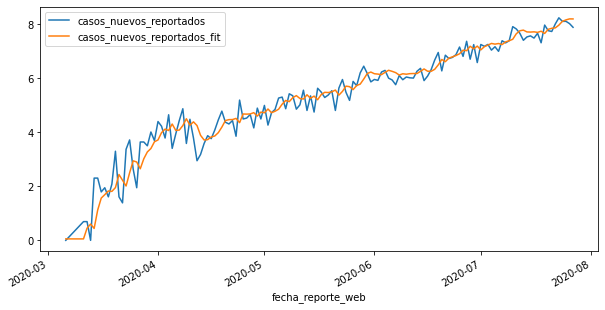

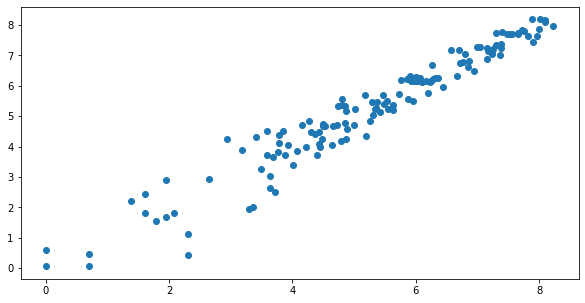

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


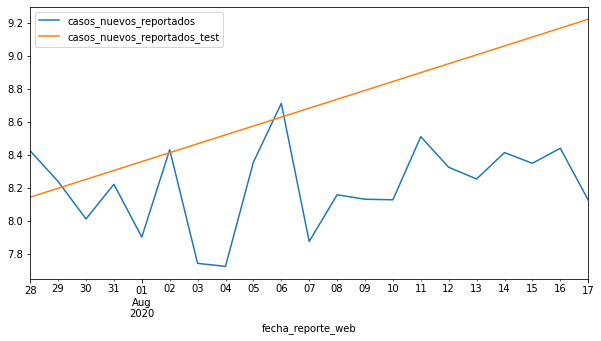

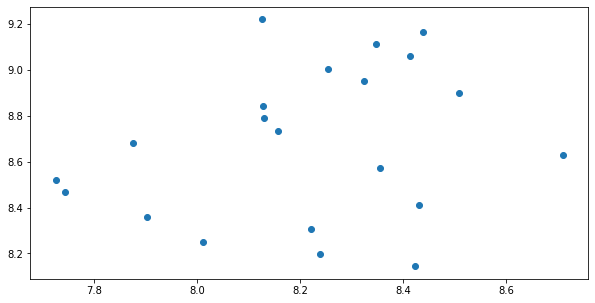

In [ ]:
M1NuevosLogTrain['casos_nuevos_reportados_fit']=arima.predict_in_sample()
plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5)).figure.savefig('3.png')

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])
plt.savefig('4.png')
plt.show()


M1NuevosLogTest['casos_nuevos_reportados_test']=arima.predict(n_periods=(len(M1NuevosLogTest))) 
plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10,5)).figure.savefig('5.png')

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_test'])
plt.savefig('6.png')
plt.show()

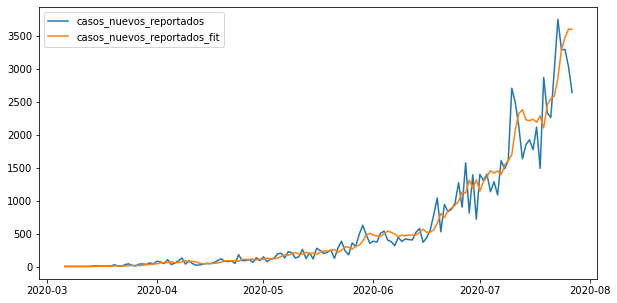

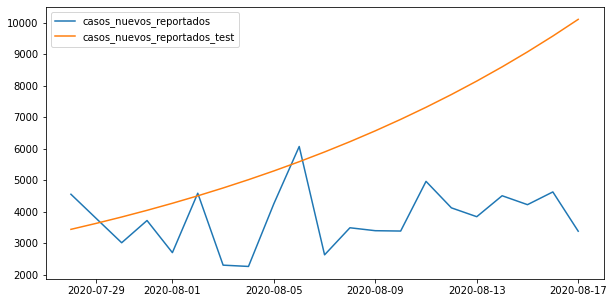

In [ ]:
FM1Nuevos=np.exp(M1NuevosLogTrain)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_fit'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_fit'])
plt.savefig('7.png')
plt.show()

FM1NuevosTest=np.exp(M1NuevosLogTest)
plt.plot(FM1NuevosTest['casos_nuevos_reportados'])
plt.plot(FM1NuevosTest['casos_nuevos_reportados_test'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_test'])
plt.savefig('8.png')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Nuevos['casos_nuevos_reportados'],FM1Nuevos['casos_nuevos_reportados_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1NuevosTest['casos_nuevos_reportados'],FM1NuevosTest['casos_nuevos_reportados_test'])
print('MSE in test: %f' % msetest)

MSE in train: 56477.058940
MSE in test: 9851056.130293


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1NuevosLogTrain=M1NuevosLog[:int(len(M1NuevosLog)*p_train)]
M1NuevosLogTest=M1NuevosLog[int(len(M1NuevosLog)*p_train):int(len(M1NuevosLog)*(p_train+p_test))]
M1NuevosLogForecast=M1NuevosLog[int(len(M1NuevosLog)*(p_train+p_test)):]
print(M1NuevosLog.shape)
print(M1NuevosLogTrain.shape)
print(M1NuevosLogTest.shape)
print(M1NuevosLogForecast.shape)

(174, 1)
(139, 1)
(21, 1)
(14, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


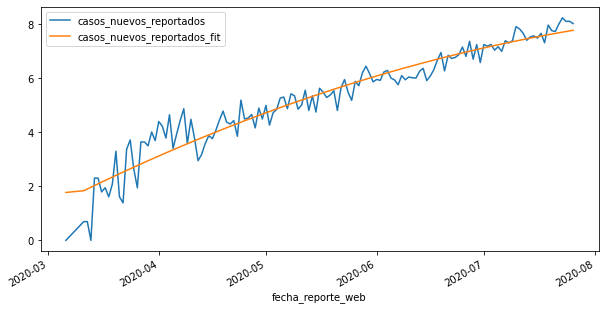

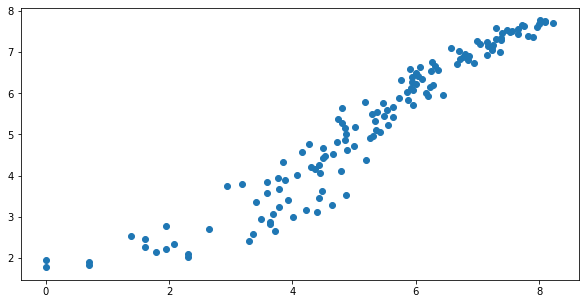

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


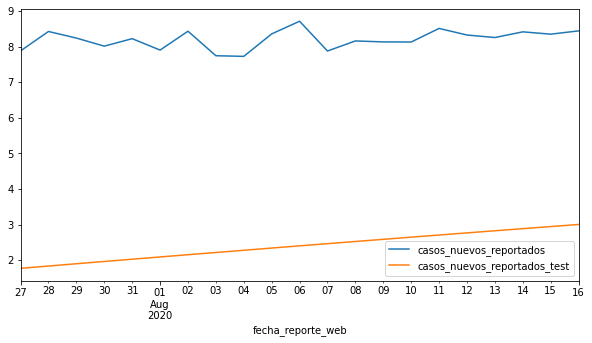

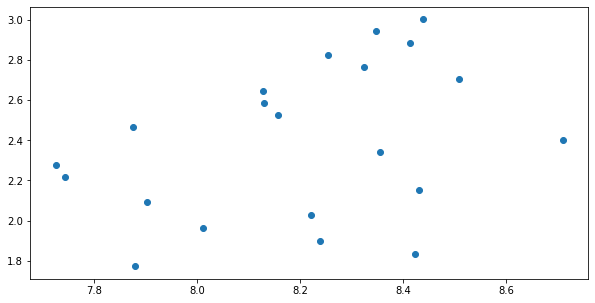

Mean squared error: 0.28
Variance score: 0.92


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1NuevosLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1NuevosLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=2)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1NuevosLogTrain['casos_nuevos_reportados'].values.reshape(-1,1))
M1NuevosLogTrain['casos_nuevos_reportados_fit']=model.predict(x_trainpoly)

plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])
plt.show()

M1NuevosLogTest['casos_nuevos_reportados_test']=model.predict(x_testpoly)
plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])))

print('Variance score: %.2f' % r2_score(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit']))

#4,3,2
#Mean squared error: 0.15, 0.19, 0.24
#Variance score: 0.96, 0.95, 0.94

# LinnearRegression() 0.24, 0.94

In [ ]:
M1NuevosLogTrain['Errores']=M1NuevosLogTrain['casos_nuevos_reportados']-M1NuevosLogTrain['casos_nuevos_reportados_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1NuevosLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.enforce_stationarity and
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / n

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -90.003
Date:                Tue, 01 Sep 2020   AIC                            186.006
Time:                        02:45:02   BIC                            194.809
Sample:                             0   HQIC                           189.583
                                - 139                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9150      0.036     25.265      0.000       0.844       0.986
ma.L1         -0.6379      0.085     -7.494      0.000      -0.805      -0.471
sigma2         0.2129      0.021     10.319      0.000       0.172       0.253
===================================================================================
Ljung-Box (Q):                       25.92   Jarque-Bera (JB):                 6.88
Prob(Q):                              0.96   Prob(JB):                         0.03
Heteroskedasticity (H):               0.13   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


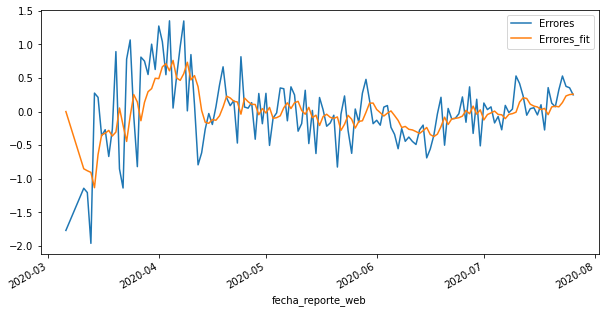

In [ ]:
M1NuevosLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1NuevosLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


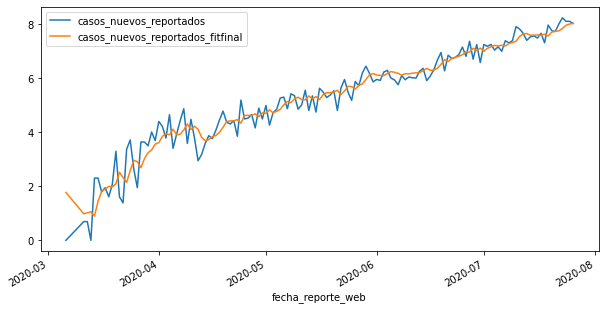

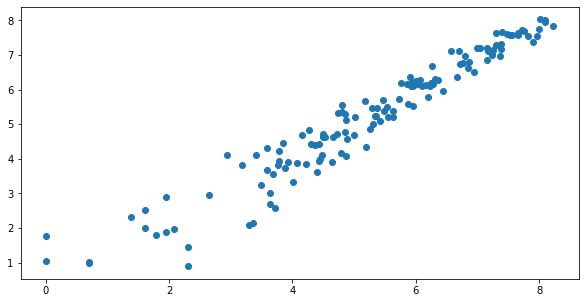

In [ ]:
M1NuevosLogTrain['casos_nuevos_reportados_fitfinal']=M1NuevosLogTrain['casos_nuevos_reportados_fit']+M1NuevosLogTrain['Errores_fit']
plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


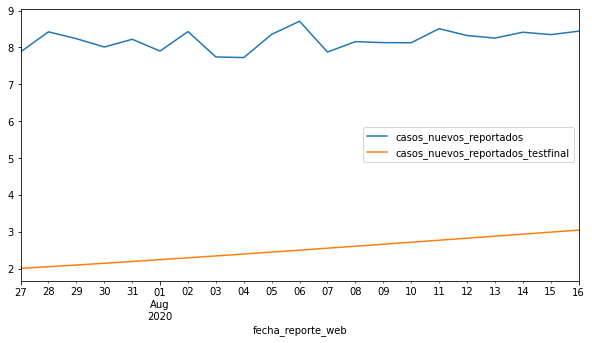

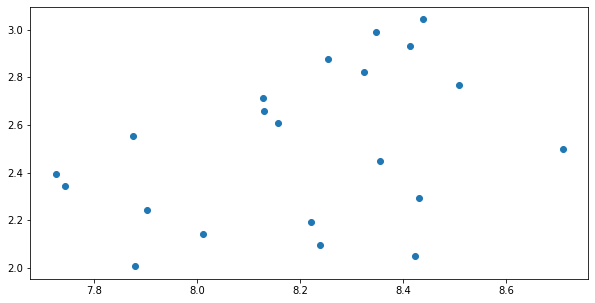

In [ ]:
M1NuevosLogTest['Errores_test']=arima.predict(n_periods=(len(M1NuevosLogTest)))
M1NuevosLogTest['casos_nuevos_reportados_testfinal']=M1NuevosLogTest['casos_nuevos_reportados_test']+M1NuevosLogTest['Errores_test']

plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_testfinal'])
plt.show() 

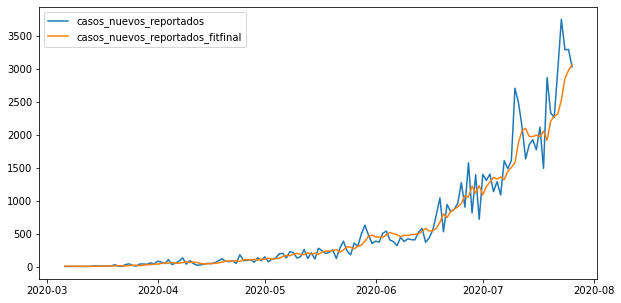

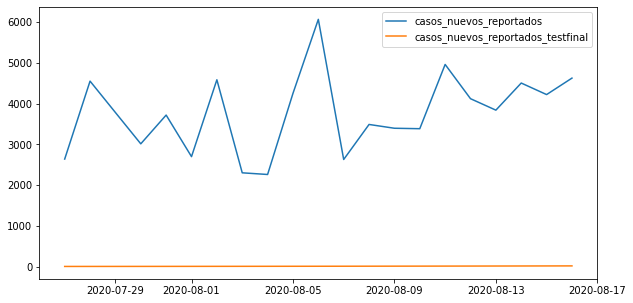

In [ ]:
FM1Nuevos=np.exp(M1NuevosLogTrain)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_fitfinal'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_fitfinal'])
plt.show()

FM1Nuevos=np.exp(M1NuevosLogTest)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_testfinal'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_testfinal'])
plt.show()

#x_fore=M1NuevosLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 1: Muerte ARIMA Y POLINOMIAL CON ERORRES ARIMA



In [ ]:
# tabla con ciudades filtradas para modelar casos fallecidos
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muerte'},inplace=True)

In [ ]:
tabla_muerte

,fecha_muerte,casos_muerte
0,2020-03-25,1
1,2020-03-26,2
2,2020-03-28,3
3,2020-03-29,1
4,2020-03-30,1
...,...,...
154,2020-08-28,52
155,2020-08-29,68
156,2020-08-30,54
157,2020-08-31,41


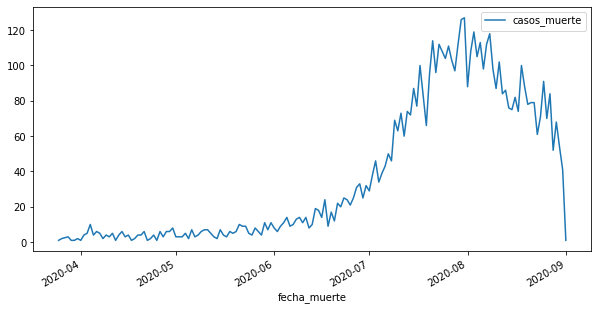

In [ ]:
tabla_muerte.plot(x='fecha_muerte',y='casos_muerte',figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


mean1=5.712500, mean2=68.962025
variance1=13.504844, variance2=1124.163115


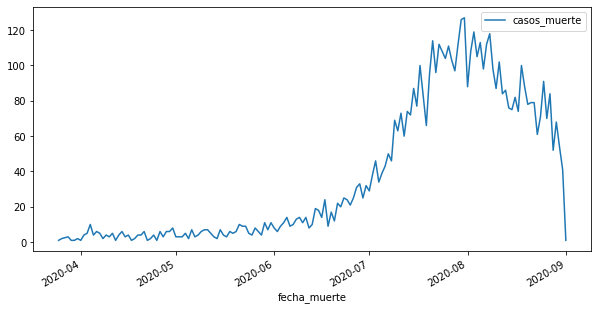

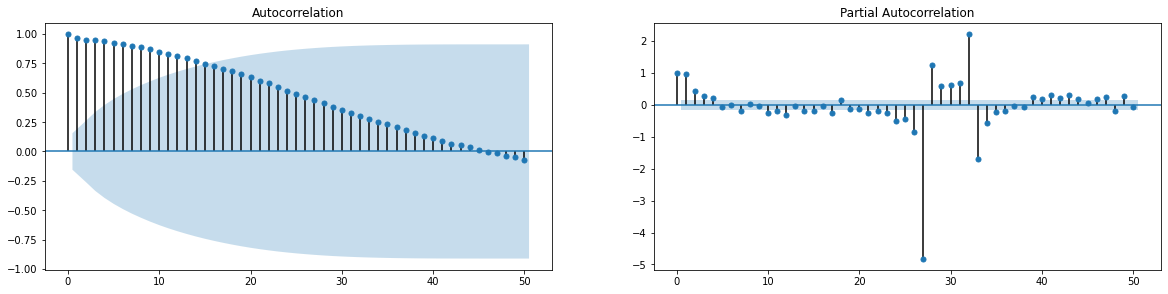

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)
M1Muerte.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Muerte.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Muerte, lags=50, ax=ax2)

X=M1Muerte.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=1.511305, mean2=4.033204
variance1=0.531467, variance2=0.606327


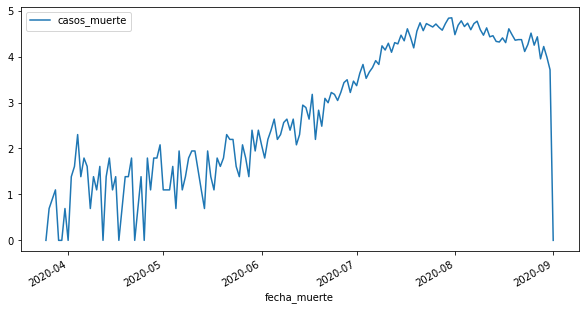

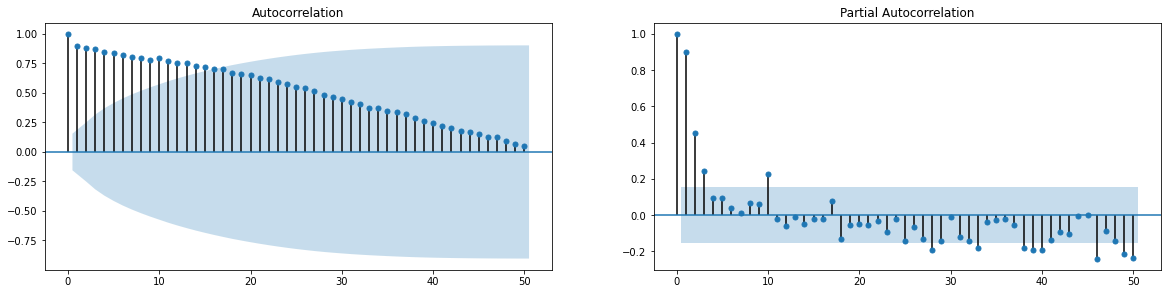

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1MuerteLog=np.log(M1Muerte)
plt.rcParams["figure.figsize"] = (10,5)
M1MuerteLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1MuerteLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1MuerteLog, lags=50, ax=ax2)

X=M1MuerteLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

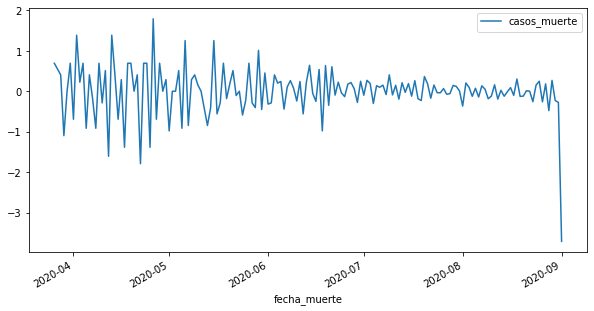

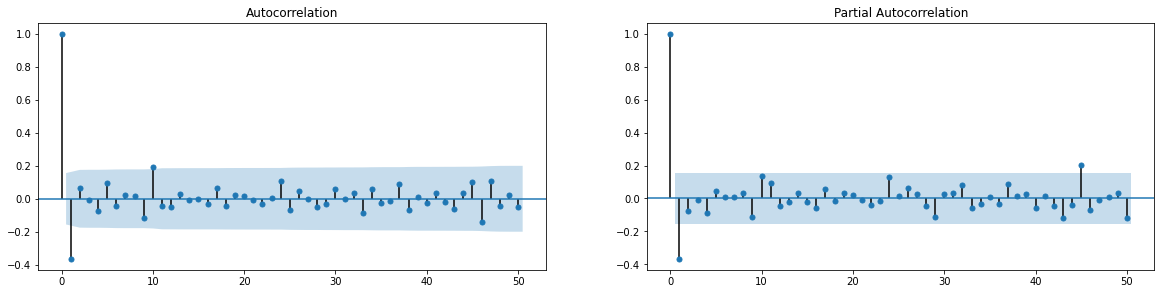

In [ ]:
# Primera diferencia para volver estacional
M1MuerteLogDif=M1MuerteLog.diff()
M1MuerteLogDif=M1MuerteLogDif[1:]
M1MuerteLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1MuerteLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1MuerteLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1MuerteLogTrain=M1MuerteLog[:int(len(M1MuerteLog)*p_train)]
M1MuerteLogTest=M1MuerteLog[int(len(M1MuerteLog)*p_train):int(len(M1MuerteLog)*(p_train+p_test))]
M1MuerteLogForecast=M1MuerteLog[int(len(M1MuerteLog)*(p_train+p_test)):]
print(M1MuerteLog.shape)
print(M1MuerteLogTrain.shape)
print(M1MuerteLogTest.shape)
print(M1MuerteLogForecast.shape)

(159, 1)
(127, 1)
(19, 1)
(13, 1)


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1MuerteLogTrain)
arima.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -79.550
Date:                Wed, 02 Sep 2020   AIC                            165.100
Time:                        18:22:03   BIC                            173.609
Sample:                             0   HQIC                           168.557
                                - 127                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0345      0.009      3.928      0.000       0.017       0.052
ma.L1         -0.8208      0.051    -16.088      0.000      -0.921      -0.721
sigma2         0.2051      0.021      9.733      0.000       0.164       0.246
===================================================================================
Ljung-Box (Q):                       35.99   Jarque-Bera (JB):                28.35
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


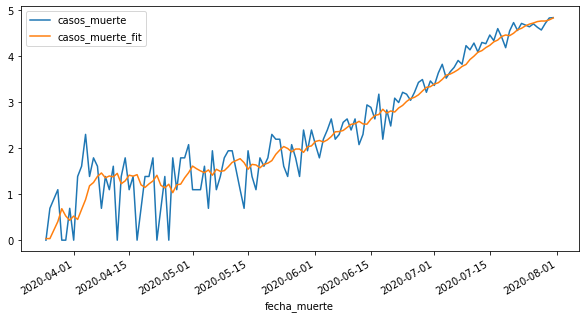

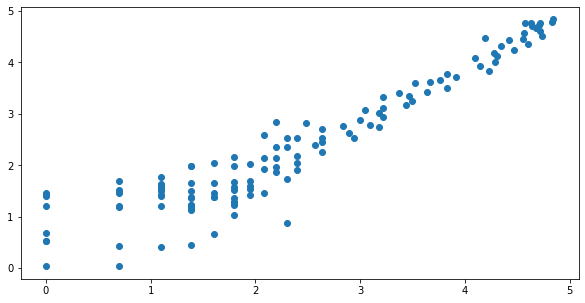

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


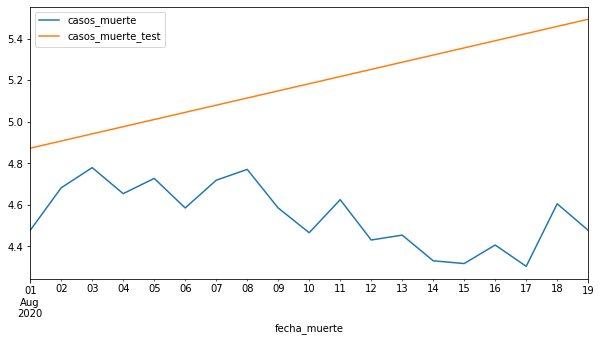

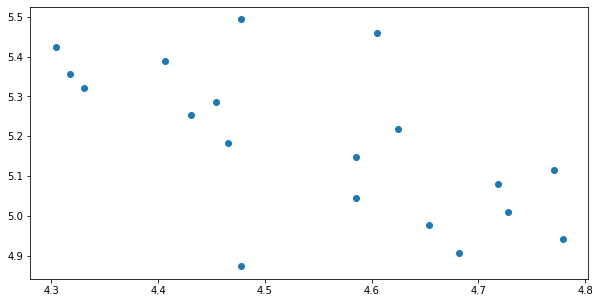

In [ ]:
M1MuerteLogTrain['casos_muerte_fit']=arima.predict_in_sample()
plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])
plt.show()



M1MuerteLogTest['casos_muerte_test']=arima.predict(n_periods=(len(M1MuerteLogTest))) 
plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_test'])
plt.show()

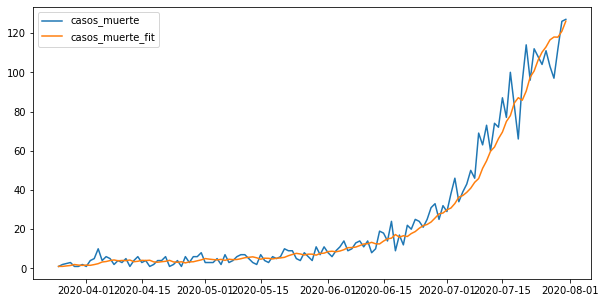

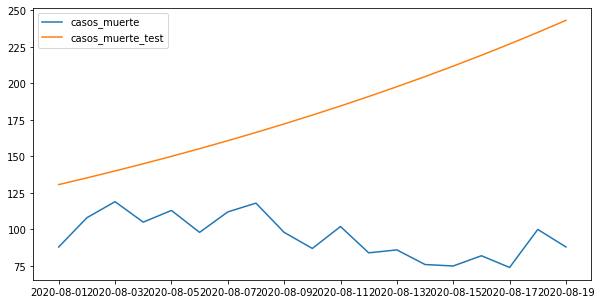

In [ ]:
FM1Muerte=np.exp(M1MuerteLogTrain)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_fit'])
plt.legend(['casos_muerte','casos_muerte_fit'])
plt.show()

FM1MuerteTest=np.exp(M1MuerteLogTest)
plt.plot(FM1MuerteTest['casos_muerte'])
plt.plot(FM1MuerteTest['casos_muerte_test'])
plt.legend(['casos_muerte','casos_muerte_test'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Muerte['casos_muerte'],FM1Muerte['casos_muerte_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1MuerteTest['casos_muerte'],FM1MuerteTest['casos_muerte_test'])
print('MSE in test: %f' % msetest)

MSE in train: 40.542107
MSE in test: 9374.722497


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1MuerteLogTrain=M1MuerteLog[:int(len(M1MuerteLog)*p_train)]
M1MuerteLogTest=M1MuerteLog[int(len(M1MuerteLog)*p_train):int(len(M1MuerteLog)*(p_train+p_test))]
M1MuerteLogForecast=M1MuerteLog[int(len(M1MuerteLog)*(p_train+p_test)):]
print(M1MuerteLog.shape)
print(M1MuerteLogTrain.shape)
print(M1MuerteLogTest.shape)
print(M1MuerteLogForecast.shape)

(157, 1)
(125, 1)
(19, 1)
(13, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


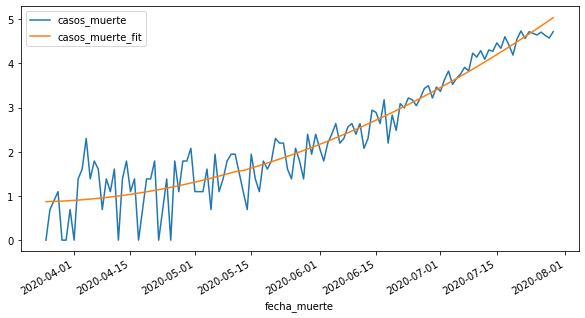

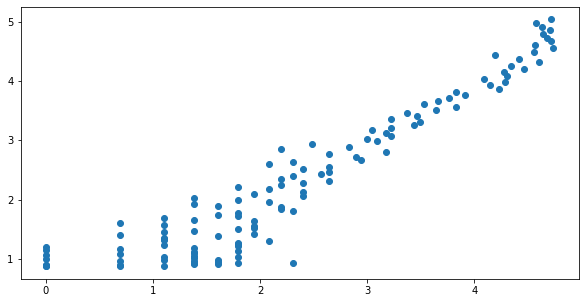

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


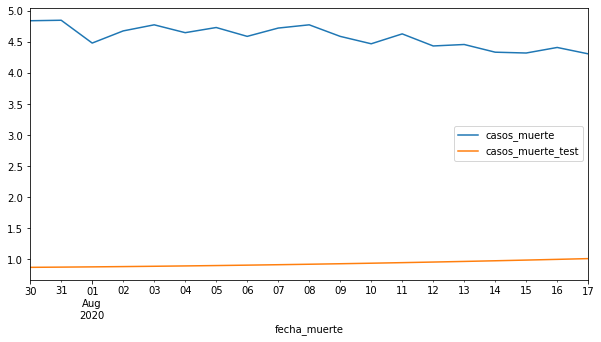

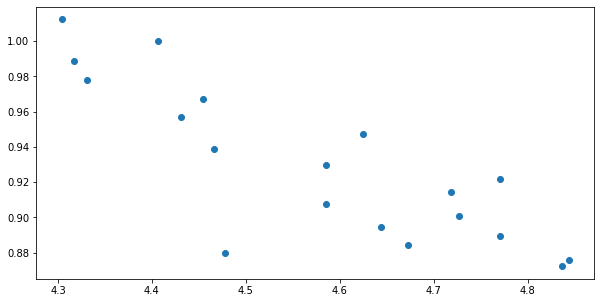

Mean squared error: 0.19
Variance score: 0.89


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1MuerteLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1MuerteLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=3)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1MuerteLogTrain['casos_muerte'].values.reshape(-1,1))
M1MuerteLogTrain['casos_muerte_fit']=model.predict(x_trainpoly)

plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])
plt.show()

M1MuerteLogTest['casos_muerte_test']=model.predict(x_testpoly)
plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])))

print('Variance score: %.2f' % r2_score(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit']))

#3
#Mean squared error: 0.11
#Variance score: 0.94

# LinnearRegression()

In [ ]:
M1MuerteLogTrain['Errores']=M1MuerteLogTrain['casos_muerte']-M1MuerteLogTrain['casos_muerte_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1MuerteLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:                        SARIMAX   Log Likelihood                 -73.633
Date:                Tue, 01 Sep 2020   AIC                            149.266
Time:                        02:47:54   BIC                            152.094
Sample:                             0   HQIC                           150.415
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1902      0.021      9.227      0.000       0.150       0.231
===================================================================================
Ljung-Box (Q):                       37.25   Jarque-Bera (JB):                 5.77
Prob(Q):                              0.59   Prob(JB):                         0.06
Heteroskedasticity (H):               0.11   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


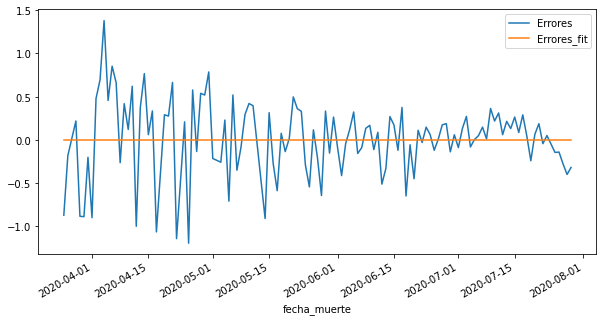

In [ ]:
M1MuerteLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1MuerteLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


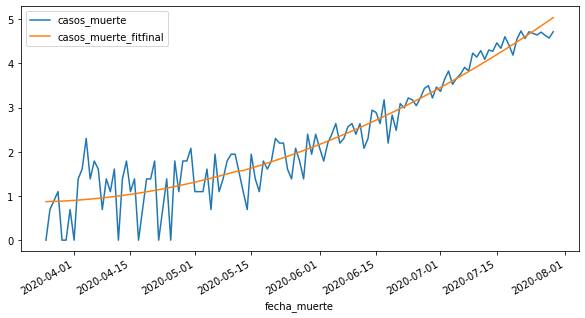

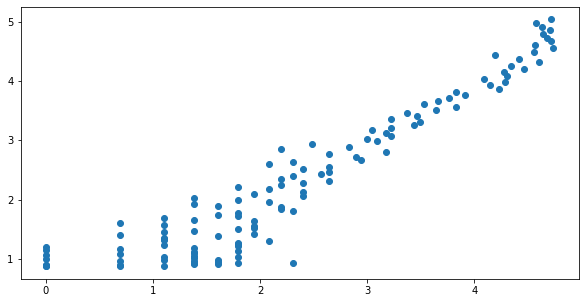

In [ ]:
M1MuerteLogTrain['casos_muerte_fitfinal']=M1MuerteLogTrain['casos_muerte_fit']+M1MuerteLogTrain['Errores_fit']
plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


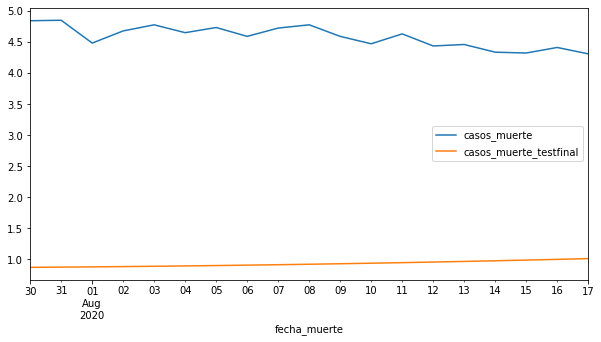

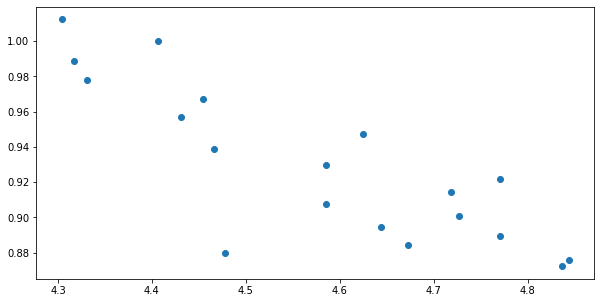

In [ ]:
M1MuerteLogTest['Errores_test']=arima.predict(n_periods=(len(M1MuerteLogTest)))
M1MuerteLogTest['casos_muerte_testfinal']=M1MuerteLogTest['casos_muerte_test']+M1MuerteLogTest['Errores_test']

plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_testfinal'])
plt.show() 

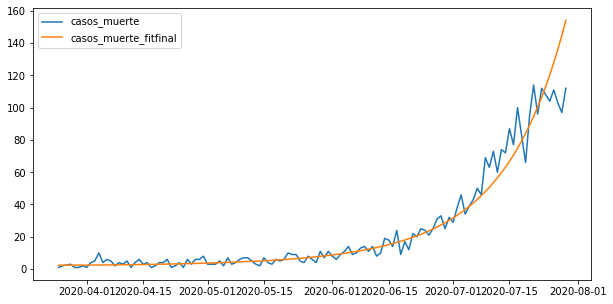

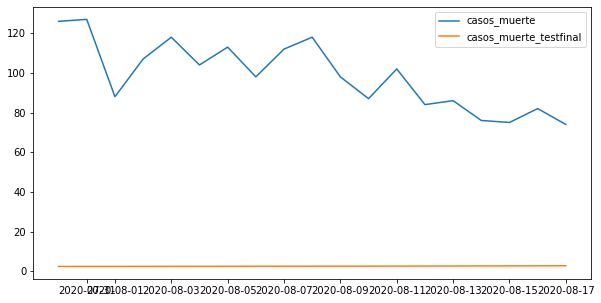

In [ ]:
FM1Muerte=np.exp(M1MuerteLogTrain)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_fitfinal'])
plt.legend(['casos_muerte','casos_muerte_fitfinal'])
plt.show()

FM1Muerte=np.exp(M1MuerteLogTest)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_testfinal'])
plt.legend(['casos_muerte','casos_muerte_testfinal'])
plt.show()

#x_fore=M1MuerteLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 1: Recuperado ARIMA Y POLINOMIAL CON ERORRES ARIMA

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperados
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

In [ ]:
tabla_recuperado

,fecha_recuperado,casos_recuperado
0,2020-03-13,1
1,2020-03-14,1
2,2020-03-20,1
3,2020-03-21,2
4,2020-03-22,2
...,...,...
162,2020-08-28,5426
163,2020-08-29,4212
164,2020-08-30,3191
165,2020-08-31,2523


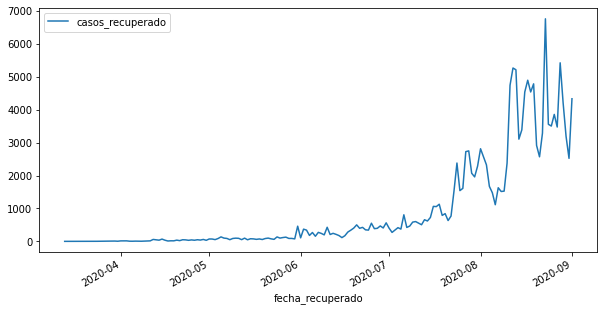

In [ ]:
tabla_recuperado.plot(x='fecha_recuperado',y='casos_recuperado',figsize=(10, 5))

mean1=77.571429, mean2=1795.108434
variance1=8719.244898, variance2=2634780.048483


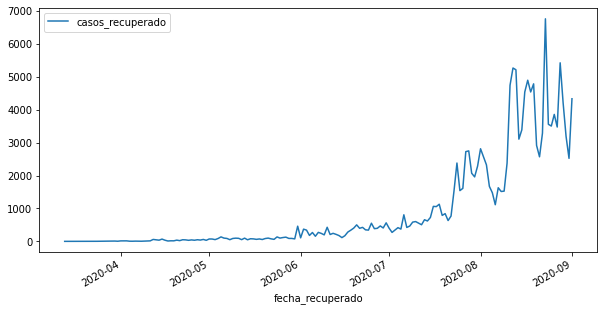

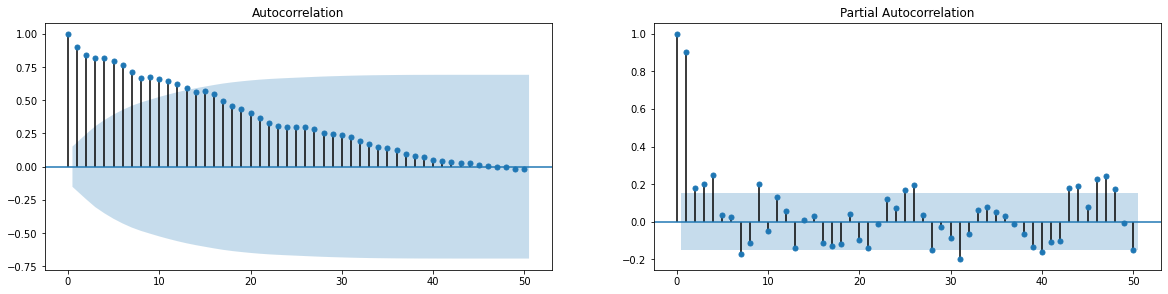

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)
M1Recuperado.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Recuperado.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Recuperado, lags=50, ax=ax2)

X=M1Recuperado.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=3.593161, mean2=7.012853
variance1=2.071376, variance2=1.084537


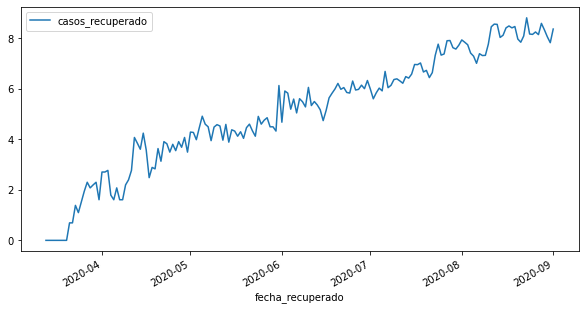

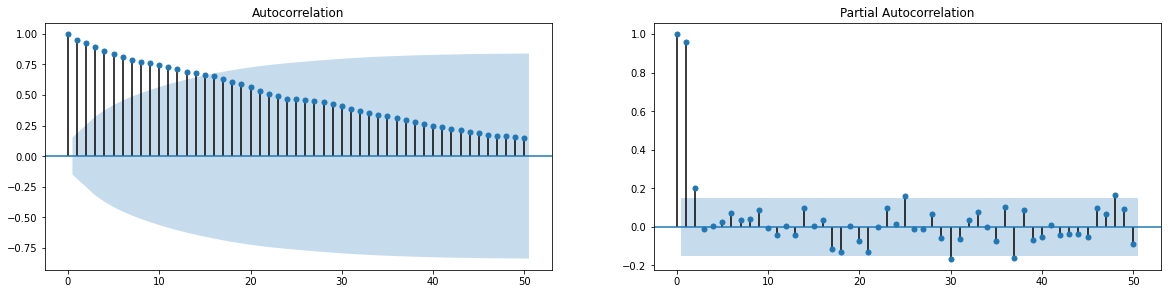

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1RecuperadoLog=np.log(M1Recuperado)
plt.rcParams["figure.figsize"] = (10,5)
M1RecuperadoLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1RecuperadoLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1RecuperadoLog, lags=50, ax=ax2)

X=M1RecuperadoLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

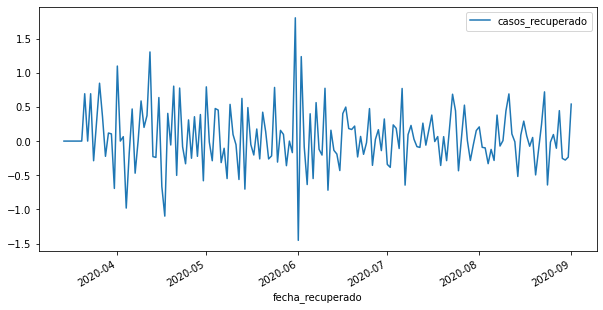

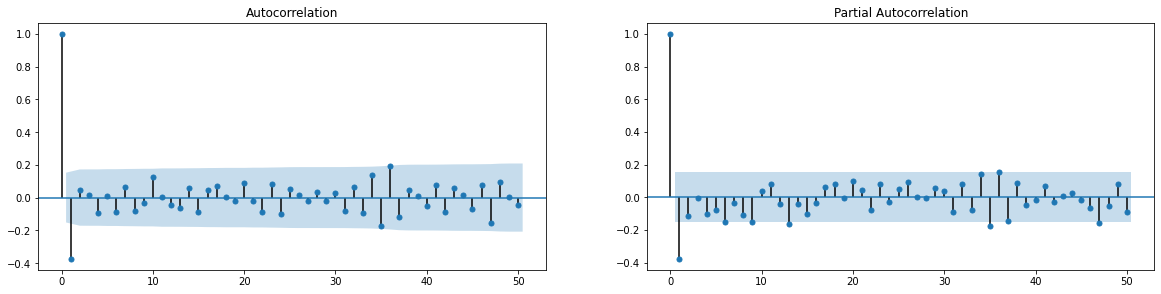

In [ ]:
# Primera diferencia para volver estacional
M1RecuperadoLogDif=M1RecuperadoLog.diff()
M1RecuperadoLogDif=M1RecuperadoLogDif[1:]
M1RecuperadoLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1RecuperadoLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1RecuperadoLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1RecuperadoLogTrain=M1RecuperadoLog[:int(len(M1RecuperadoLog)*p_train)]
M1RecuperadoLogTest=M1RecuperadoLog[int(len(M1RecuperadoLog)*p_train):int(len(M1RecuperadoLog)*(p_train+p_test))]
M1RecuperadoLogForecast=M1RecuperadoLog[int(len(M1RecuperadoLog)*(p_train+p_test)):]
print(M1RecuperadoLog.shape)
print(M1RecuperadoLogTrain.shape)
print(M1RecuperadoLogTest.shape)
print(M1RecuperadoLogForecast.shape)

(167, 1)
(133, 1)
(20, 1)
(14, 1)


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1RecuperadoLogTrain)
arima.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  133
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -76.657
Date:                Wed, 02 Sep 2020   AIC                            159.314
Time:                        18:25:04   BIC                            167.962
Sample:                             0   HQIC                           162.828
                                - 133                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0586      0.021      2.770      0.006       0.017       0.100
ma.L1         -0.4527      0.074     -6.094      0.000      -0.598      -0.307
sigma2         0.1867      0.018     10.657      0.000       0.152       0.221
===================================================================================
Ljung-Box (Q):                       35.59   Jarque-Bera (JB):                17.70
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


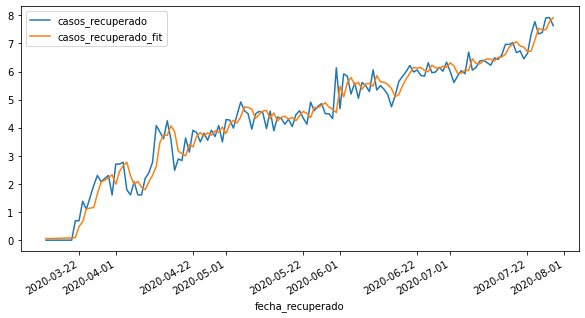

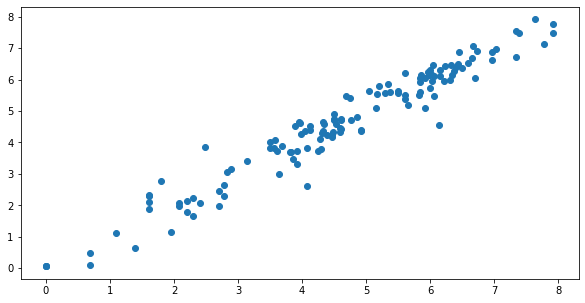

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


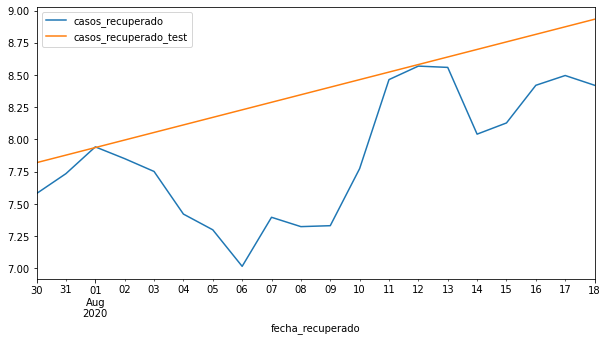

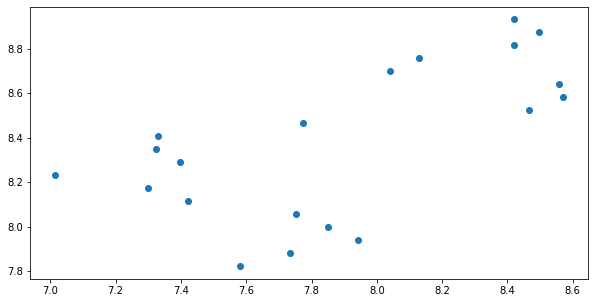

In [ ]:
M1RecuperadoLogTrain['casos_recuperado_fit']=arima.predict_in_sample()
plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])
plt.show()



M1RecuperadoLogTest['casos_recuperado_test']=arima.predict(n_periods=(len(M1RecuperadoLogTest))) 
plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_test'])
plt.show()

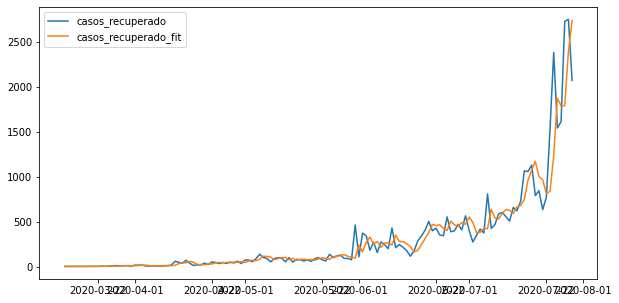

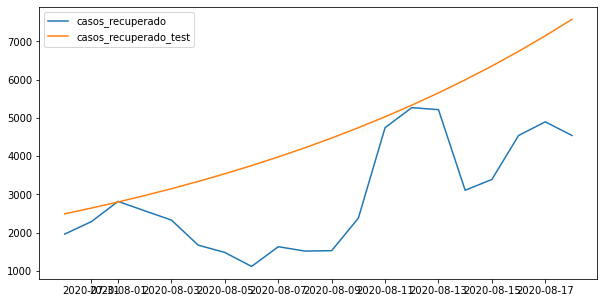

In [ ]:
FM1Recuperado=np.exp(M1RecuperadoLogTrain)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_fit'])
plt.legend(['casos_recuperado','casos_recuperado_fit'])
plt.show()

FM1RecuperadoTest=np.exp(M1RecuperadoLogTest)
plt.plot(FM1RecuperadoTest['casos_recuperado'])
plt.plot(FM1RecuperadoTest['casos_recuperado_test'])
plt.legend(['casos_recuperado','casos_recuperado_test'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Recuperado['casos_recuperado'],FM1Recuperado['casos_recuperado_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1RecuperadoTest['casos_recuperado'],FM1RecuperadoTest['casos_recuperado_test'])
print('MSE in test: %f' % msetest)


MSE in train: 34380.053950
MSE in test: 3943584.492494


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1RecuperadoLogTrain=M1RecuperadoLog[:int(len(M1RecuperadoLog)*p_train)]
M1RecuperadoLogTest=M1RecuperadoLog[int(len(M1RecuperadoLog)*p_train):int(len(M1RecuperadoLog)*(p_train+p_test))]
M1RecuperadoLogForecast=M1RecuperadoLog[int(len(M1RecuperadoLog)*(p_train+p_test)):]
print(M1RecuperadoLog.shape)
print(M1RecuperadoLogTrain.shape)
print(M1RecuperadoLogTest.shape)
print(M1RecuperadoLogForecast.shape)

(165, 1)
(132, 1)
(19, 1)
(14, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


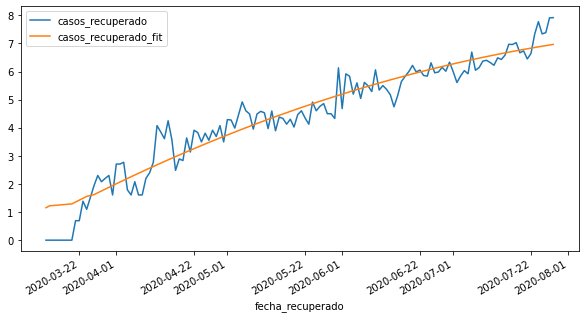

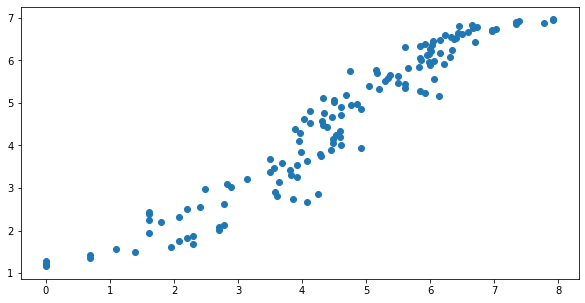

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


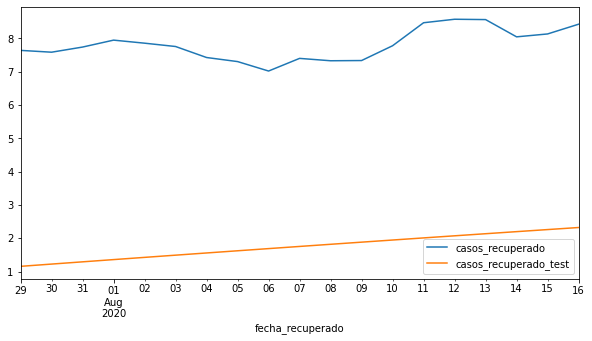

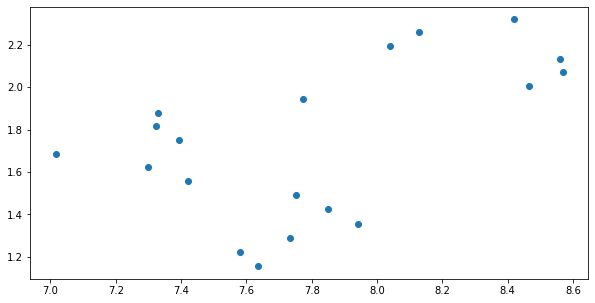

Mean squared error: 0.26
Variance score: 0.92


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1RecuperadoLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1RecuperadoLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=2)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1RecuperadoLogTrain['casos_recuperado'].values.reshape(-1,1))
M1RecuperadoLogTrain['casos_recuperado_fit']=model.predict(x_trainpoly)

plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])
plt.show()

M1RecuperadoLogTest['casos_recuperado_test']=model.predict(x_testpoly)
plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])))

print('Variance score: %.2f' % r2_score(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit']))

#
#Mean squared error: 0.24
#Variance score: 0.94

# LinnearRegression() 

In [ ]:
M1RecuperadoLogTrain['Errores']=M1RecuperadoLogTrain['casos_recuperado']-M1RecuperadoLogTrain['casos_recuperado_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1RecuperadoLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.enforce_stationarity 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 -68.802
Date:                Tue, 01 Sep 2020   AIC                            147.604
Time:                        02:50:37   BIC                            162.018
Sample:                             0   HQIC                           153.462
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2857      0.248      5.193      0.000       0.800       1.771
ar.L2         -0.5509      0.197     -2.790      0.005      -0.938      -0.164
ma.L1         -0.8745      0.242     -3.607      0.000      -1.350      -0.399
ma.L2          0.4930      0.115      4.305      0.000       0.269       0.717
sigma2         0.1652      0.018      8.947      0.000       0.129       0.201
===================================================================================
Ljung-Box (Q):                       26.71   Jarque-Bera (JB):                 8.17
Prob(Q):                              0.95   Prob(JB):                         0.02
Heteroskedasticity (H):               0.43   Skew:                             0.42
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


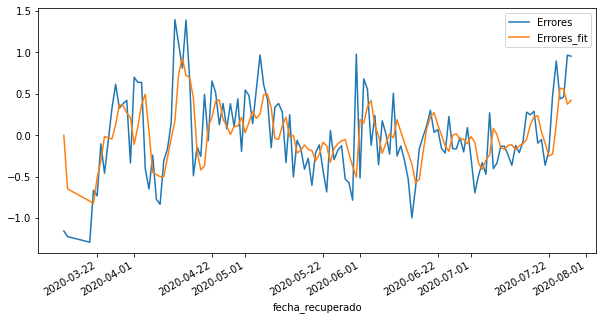

In [ ]:
M1RecuperadoLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1RecuperadoLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


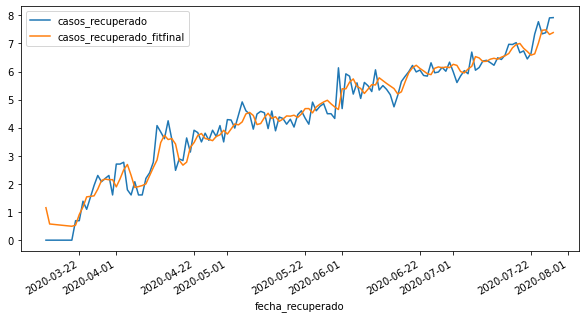

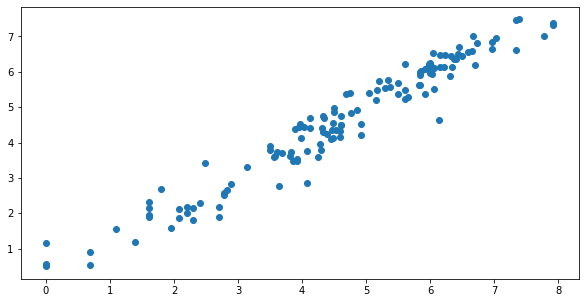

In [ ]:
M1RecuperadoLogTrain['casos_recuperado_fitfinal']=M1RecuperadoLogTrain['casos_recuperado_fit']+M1RecuperadoLogTrain['Errores_fit']
plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


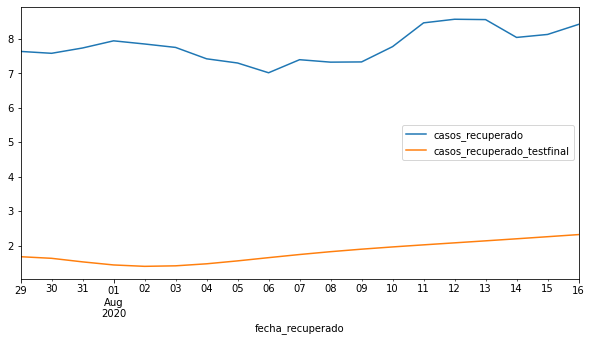

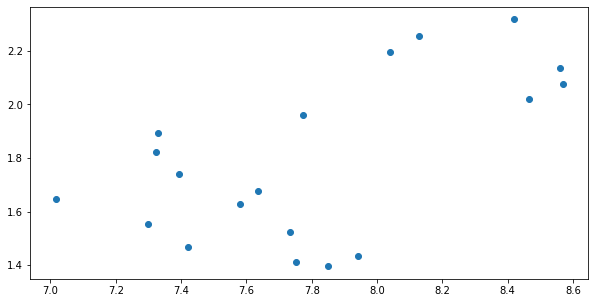

In [ ]:
M1RecuperadoLogTest['Errores_test']=arima.predict(n_periods=(len(M1RecuperadoLogTest)))
M1RecuperadoLogTest['casos_recuperado_testfinal']=M1RecuperadoLogTest['casos_recuperado_test']+M1RecuperadoLogTest['Errores_test']

plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_testfinal'])
plt.show() 

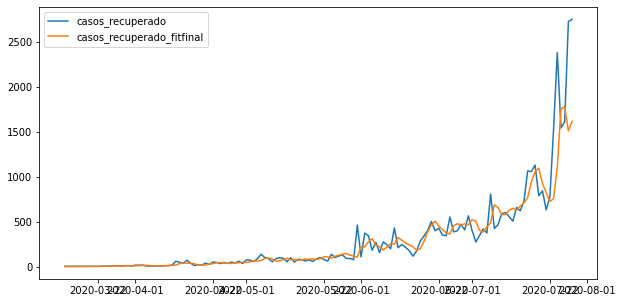

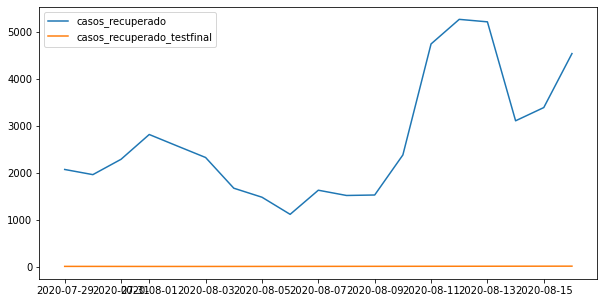

In [ ]:
FM1Recuperado=np.exp(M1RecuperadoLogTrain)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_fitfinal'])
plt.legend(['casos_recuperado','casos_recuperado_fitfinal'])
plt.show()

FM1Recuperado=np.exp(M1RecuperadoLogTest)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_testfinal'])
plt.legend(['casos_recuperado','casos_recuperado_testfinal'])
plt.show()

#x_fore=M1NuevosLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 2: Nuevos RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


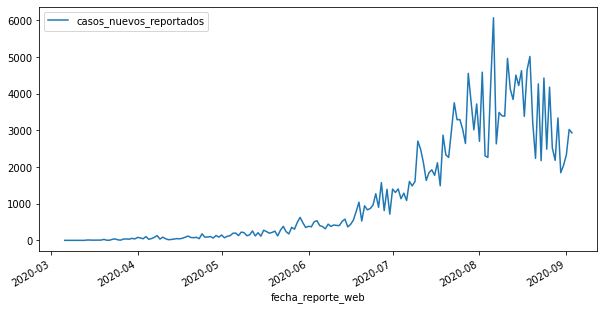

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M2Nuevos=M2Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)
M2Nuevos.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2NuevosTrain=M2Nuevos[:int(len(M2Nuevos)*p_train)]
M2NuevosTest=M2Nuevos[int(len(M2Nuevos)*p_train):int(len(M2Nuevos)*(p_train+p_test))]
M2NuevosForecast=M2Nuevos[int(len(M2Nuevos)*(p_train+p_test)):]
print(M2Nuevos.shape)
print(M2NuevosTrain.shape)
print(M2NuevosTest.shape)
print(M2NuevosForecast.shape)

(178, 1)
(142, 1)
(21, 1)
(15, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2NuevosTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2NuevosTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(135, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
5/5 [==============================] - 0s 18ms/step - loss: 0.0547
Epoch 2/150
5/5 [==============================] - 0s 17ms/step - loss: 0.0400
Epoch 3/150
5/5 [==============================] - 0s 16ms/step - loss: 0.0243
Epoch 4/150
5/5 [==============================] - 0s 16ms/step - loss: 0.0126
Epoch 5/150
5/5 [==============================] - 0s 16ms/step - loss: 0.0092
Epoch 6/150
5/5 [==============================] - 0s 16ms/step - loss: 0.0053
Epoch 7/150
5/5 [==============================] - 0s 16ms/step - loss: 0.0047
Epoch 8/150
5/5 [==============================] - 0s 16ms/step - loss: 0.0062
Epoch 9/150
5/5 [==============================] - 0s 15ms/step - loss: 0.0049
Epoch 10/150
5/5 [==============================] - 0s 16ms/step - loss: 0.0049
Epoch 11/150
5/5 [==============================] - 0s 16ms/step - loss: 0.0058
Epoch 12/150
5/5 [==============================] - 0s 16ms/step - loss: 0.0045
Epoch 13/150
5/5 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModBogotaNuevos.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Nuevos[:int(len(M2Nuevos)*p_train)]
dataset_test=M2Nuevos[int(len(M2Nuevos)*p_train):int(len(M2Nuevos)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2NuevosTrain['casos_nuevos_reportados_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2NuevosTest['casos_nuevos_reportados_test']=predicted

(21, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


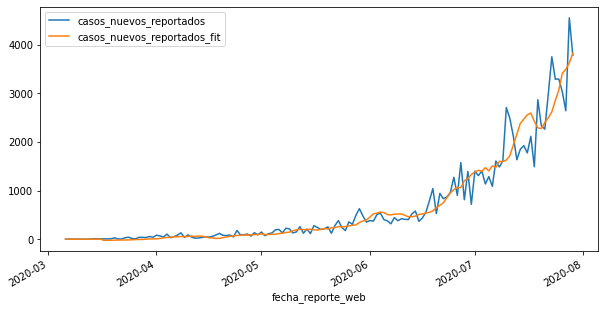

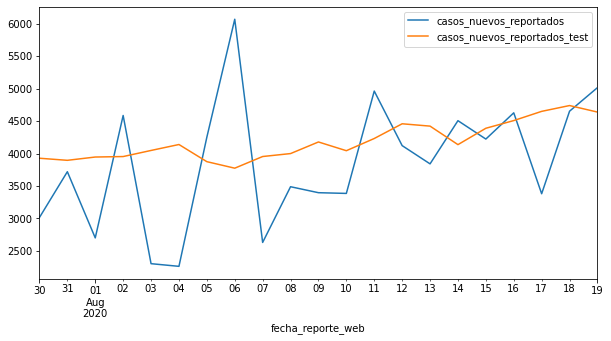

In [ ]:
plot=M2NuevosTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5))
plot=M2NuevosTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2NuevosTrain['casos_nuevos_reportados'],M2NuevosTrain['casos_nuevos_reportados_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2NuevosTest['casos_nuevos_reportados'],M2NuevosTest['casos_nuevos_reportados_test'])
print('MSE in test: %f' % msetest)

MSE in train: 72640.232153
MSE in test: 988153.806215


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


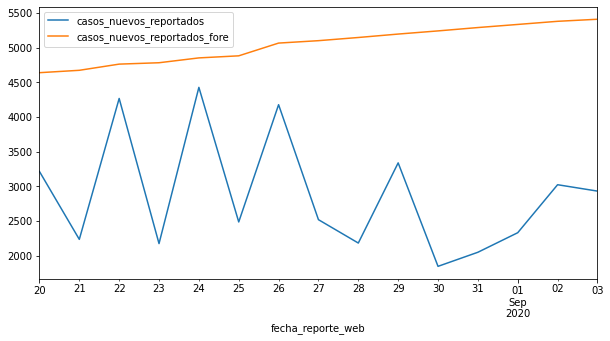

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,16):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2NuevosForecast['casos_nuevos_reportados_fore']=fore

plot=M2NuevosForecast[['casos_nuevos_reportados', 'casos_nuevos_reportados_fore']].plot(figsize=(10, 5))

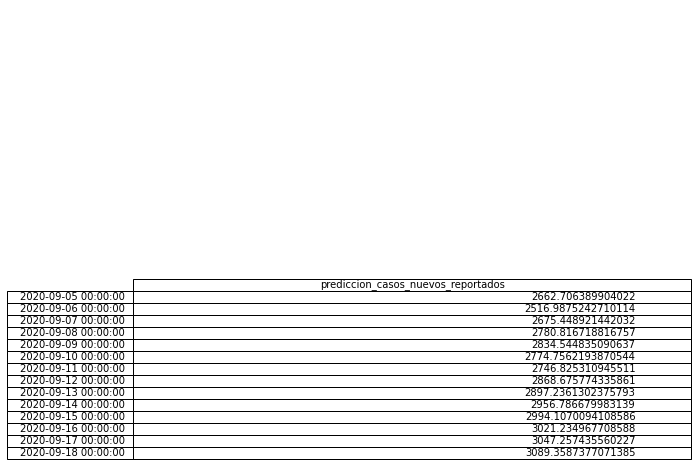

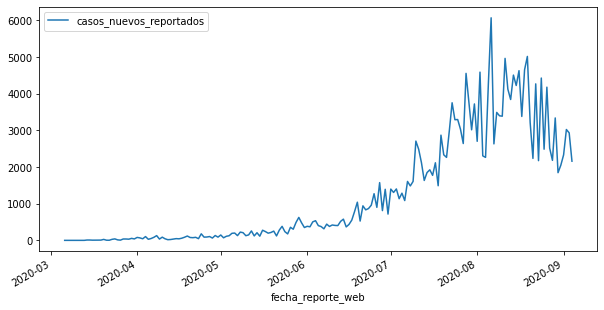

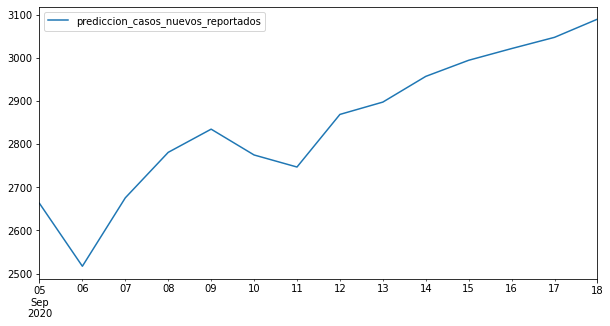

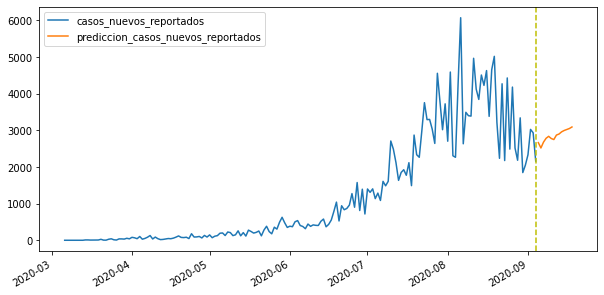

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M2Nuevos=M2Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Nuevos[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

from keras.models import load_model
model = load_model('ModBogotaNuevos.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

BogotaNuevos=sc.inverse_transform(b)

import datetime
index=[M2Nuevos.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
BogotaNuevos=pd.DataFrame(data=BogotaNuevos, index=index, columns=['prediccion_casos_nuevos_reportados'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, BogotaNuevos) 
plt.savefig('images/15.png')

M2Nuevos.plot().figure.savefig('images/13.png')

BogotaNuevos.plot().figure.savefig('images/14.png')

total=pd.concat((M2Nuevos,BogotaNuevos),axis = 0)
total.plot()
plt.axvline(x=M2Nuevos.index[-1],color='y',linestyle='--')
plt.savefig('images/16.png')

BogotaNuevos.to_excel('BogotaNuevos.xlsx')

# Metodología 2: Muerte RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos fallecidos
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muerte'},inplace=True)

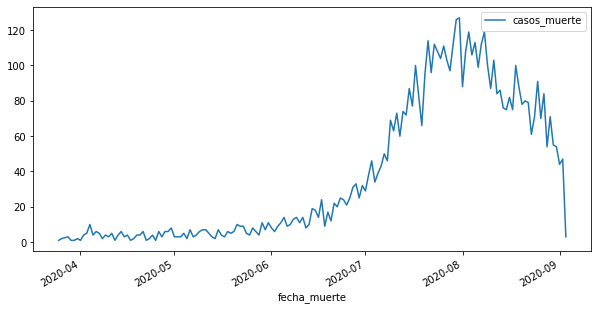

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)
M2Muerte.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2MuerteTrain=M2Muerte[:int(len(M2Muerte)*p_train)]
M2MuerteTest=M2Muerte[int(len(M2Muerte)*p_train):int(len(M2Muerte)*(p_train+p_test))]
M2MuerteForecast=M2Muerte[int(len(M2Muerte)*(p_train+p_test)):]
print(M2Muerte.shape)
print(M2MuerteTrain.shape)
print(M2MuerteTest.shape)
print(M2MuerteForecast.shape)

(161, 1)
(128, 1)
(20, 1)
(13, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2MuerteTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2MuerteTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(121, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
4/4 [==============================] - 0s 16ms/step - loss: 0.1065
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0532
Epoch 3/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0447
Epoch 4/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0140
Epoch 5/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0080
Epoch 6/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0138
Epoch 7/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0083
Epoch 8/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0052
Epoch 9/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0053
Epoch 10/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0057
Epoch 11/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0042
Epoch 12/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0036
Epoch 13/150
4/4 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModBogotaMuerte.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Muerte[:int(len(M2Muerte)*p_train)]
dataset_test=M2Muerte[int(len(M2Muerte)*p_train):int(len(M2Muerte)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2MuerteTrain['casos_muerte_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2MuerteTest['casos_muerte_test']=predicted

(20, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


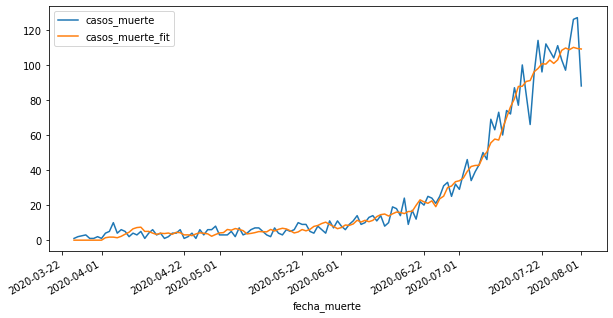

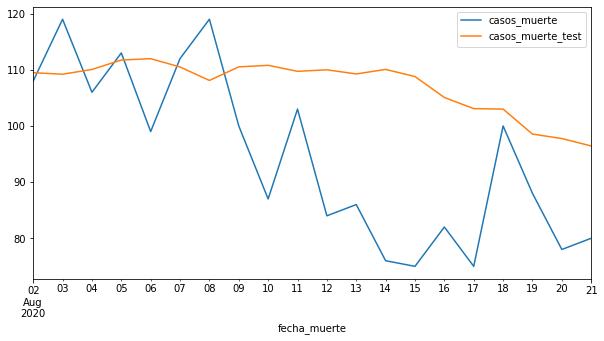

In [ ]:
plot=M2MuerteTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))
plot=M2MuerteTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2MuerteTrain['casos_muerte'],M2MuerteTrain['casos_muerte_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2MuerteTest['casos_muerte'],M2MuerteTest['casos_muerte_test'])
print('MSE in test: %f' % msetest)

MSE in train: 33.930539
MSE in test: 337.466189


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


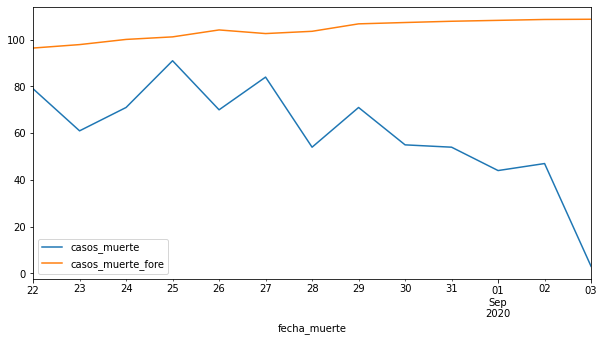

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,14):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2MuerteForecast['casos_muerte_fore']=fore

plot=M2MuerteForecast[['casos_muerte', 'casos_muerte_fore']].plot(figsize=(10, 5))

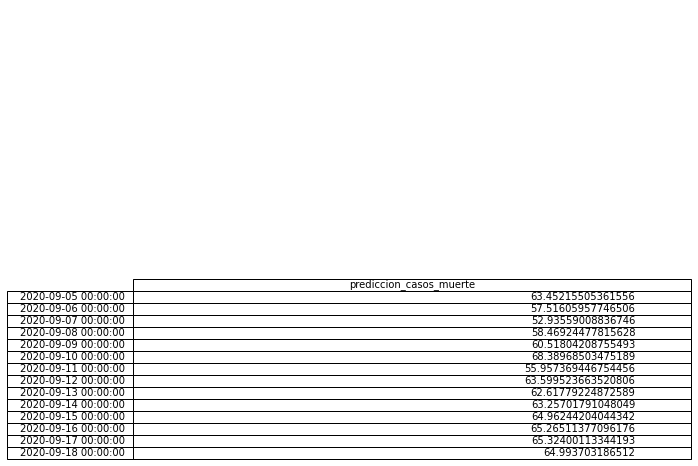

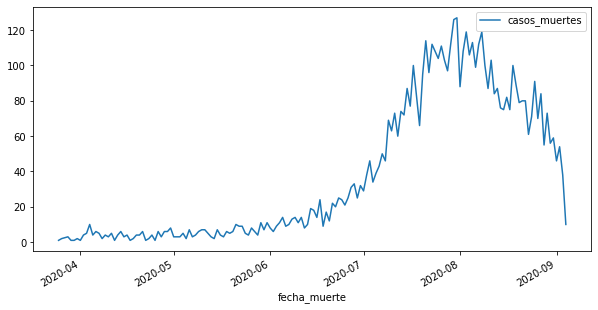

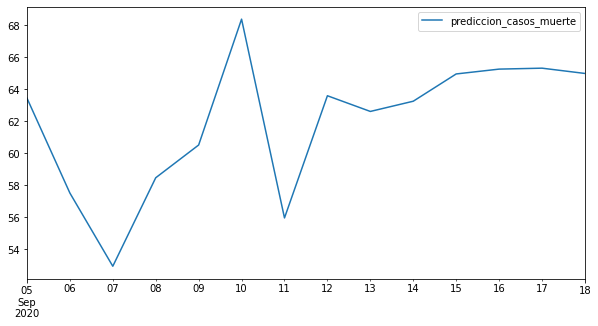

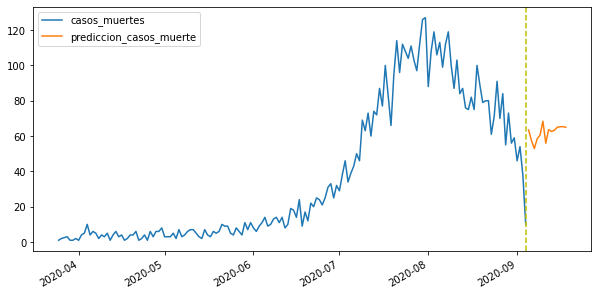

In [ ]:
# tabla con ciudades filtradas para modelar casos muerte
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muertes'},inplace=True)

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Muerte[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

model = load_model('ModBogotaMuerte.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

BogotaMuerte=sc.inverse_transform(b)

import datetime
index=[M2Muerte.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
BogotaMuerte=pd.DataFrame(data=BogotaMuerte, index=index, columns=['prediccion_casos_muerte'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, BogotaMuerte) 
plt.savefig('images/19.png')

M2Muerte.plot().figure.savefig('images/17.png')

BogotaMuerte.plot().figure.savefig('images/18.png')

total=pd.concat((M2Muerte,BogotaMuerte),axis = 0)
total.plot()
plt.axvline(x=M2Muerte.index[-1],color='y',linestyle='--')
plt.savefig('images/20.png')

BogotaMuerte.to_excel('BogotaMuerte.xlsx')

# Metodología 2: Recuperados RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperados
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

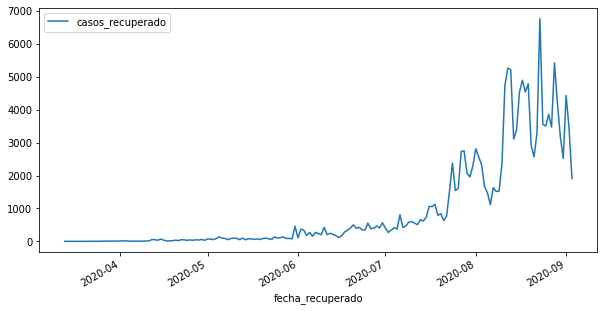

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)
M2Recuperado.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2RecuperadoTrain=M2Recuperado[:int(len(M2Recuperado)*p_train)]
M2RecuperadoTest=M2Recuperado[int(len(M2Recuperado)*p_train):int(len(M2Recuperado)*(p_train+p_test))]
M2RecuperadoForecast=M2Recuperado[int(len(M2Recuperado)*(p_train+p_test)):]
print(M2Recuperado.shape)
print(M2RecuperadoTrain.shape)
print(M2RecuperadoTest.shape)
print(M2RecuperadoForecast.shape)

(169, 1)
(135, 1)
(20, 1)
(14, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2RecuperadoTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2RecuperadoTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(128, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0488
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0319
Epoch 3/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0271
Epoch 4/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0134
Epoch 5/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0125
Epoch 6/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0098
Epoch 7/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0090
Epoch 8/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0099
Epoch 9/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0090
Epoch 10/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0073
Epoch 11/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0086
Epoch 12/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0078
Epoch 13/150
4/4 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModBogotaRecuperado.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Recuperado[:int(len(M2Recuperado)*p_train)]
dataset_test=M2Recuperado[int(len(M2Recuperado)*p_train):int(len(M2Recuperado)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2RecuperadoTrain['casos_recuperado_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2RecuperadoTest['casos_recuperado_test']=predicted

(20, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


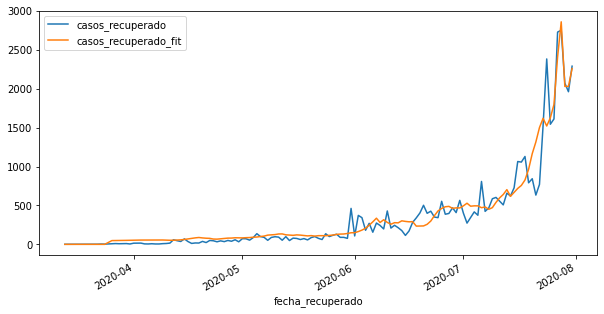

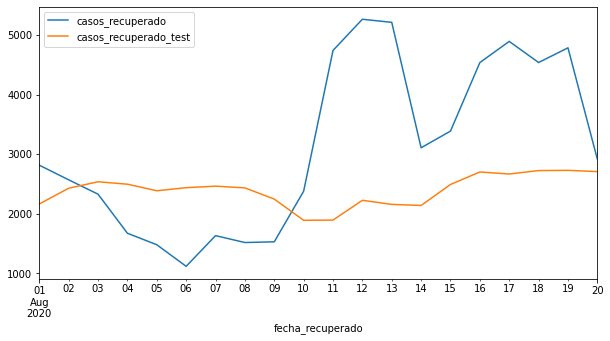

In [ ]:
plot=M2RecuperadoTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))
plot=M2RecuperadoTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2RecuperadoTrain['casos_recuperado'],M2RecuperadoTrain['casos_recuperado_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2RecuperadoTest['casos_recuperado'],M2RecuperadoTest['casos_recuperado_test'])
print('MSE in test: %f' % msetest)

MSE in train: 23866.349937
MSE in test: 2520490.802032


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


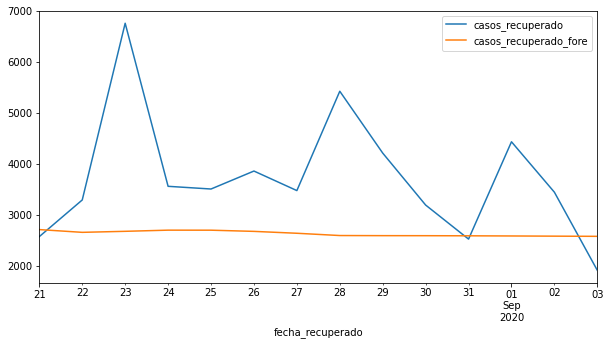

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2RecuperadoForecast['casos_recuperado_fore']=fore

plot=M2RecuperadoForecast[['casos_recuperado', 'casos_recuperado_fore']].plot(figsize=(10, 5))

Terminé recuperados


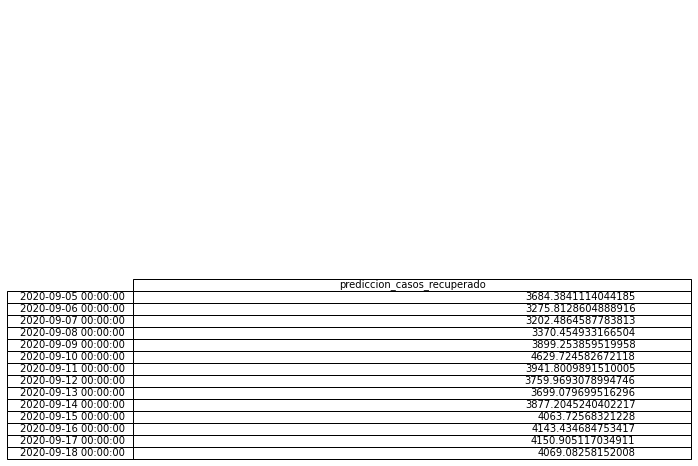

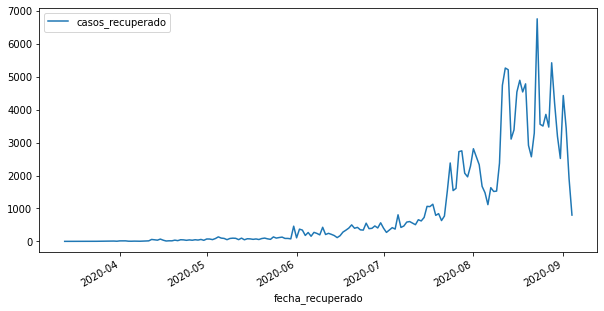

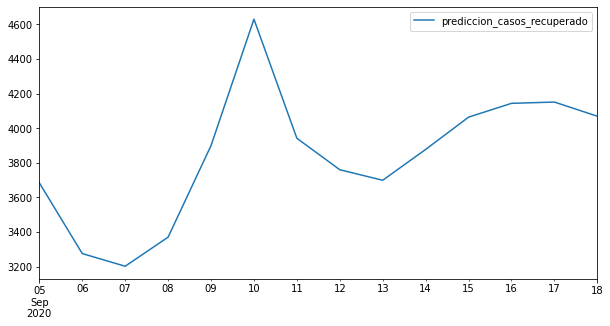

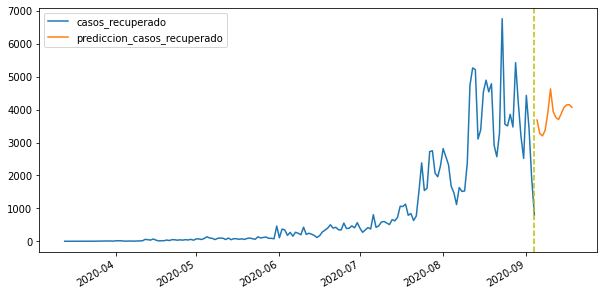

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperado
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Recuperado[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

model = load_model('ModBogotaRecuperado.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

BogotaRecuperado=sc.inverse_transform(b)

import datetime
index=[M2Recuperado.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
BogotaRecuperado=pd.DataFrame(data=BogotaRecuperado, index=index, columns=['prediccion_casos_recuperado'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, BogotaRecuperado) 
plt.savefig('images/23.png')

M2Recuperado.plot().figure.savefig('images/21.png')

BogotaRecuperado.plot().figure.savefig('images/22.png')

total=pd.concat((M2Recuperado,BogotaRecuperado),axis = 0)
total.plot()
plt.axvline(x=M2Recuperado.index[-1],color='y',linestyle='--')
plt.savefig('images/24.png')


BogotaRecuperado.to_excel('BogotaRecuperado.xlsx')

print("Terminé recuperados")